# author: Levon Abramian, J4132
# Task 6. Algorithms on graphs. Path search algorithms on weighted graphs

### The use of path search algorithms on weighted graphs (Dijkstra's, A* and BellmanFord algorithms)

In [1]:
import functools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import time

from dataclasses import dataclass
from random import randint
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
VERT_N = 100
EDGE_N = 500

In [3]:
MIN_WEIGHT = 1
MAX_WEIGHT = 1000

In [4]:
INFINITY = 1e8

In [5]:
def time_elapsed(n=10):
    def decorator_time_elapsed(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            total_time = 0
            for _ in range(n):
                start_time = time.perf_counter()
                result = func(*args, **kwargs)
                end_time = time.perf_counter()
                total_time += (end_time - start_time)
            
            avg_time = total_time / n
            return result, avg_time
        return wrapper
    return decorator_time_elapsed

In [6]:
def generate_adjacency_matrix(num_verts, num_edges):
    adj_matrix = [[0
                   for _ in range(num_verts)]
                      for _ in range(num_verts)]
    current_edges_num = 0

    while current_edges_num < num_edges:
        v = randint(0, num_verts - 1)
        u = randint(0, num_verts - 1)

        if u != v and adj_matrix[u][v] == 0:
            weight = randint(MIN_WEIGHT, MAX_WEIGHT)
            adj_matrix[v][u] = weight
            adj_matrix[u][v] = weight
            current_edges_num += 1
    
    return adj_matrix

In [7]:
@dataclass
class Pair:
    to: int
    weight: int

def adj_matrix_to_adj_lst(adjacency_matrix):
    n = len(adjacency_matrix)
    adjacency_list = [[Pair(j, adjacency_matrix[i][j])
                           for j in range(n) if adjacency_matrix[i][j] != 0]
                              for i in range(n)]
    return adjacency_list

In [8]:
def relax(vertex: int, adj_matrix, distance):
    for i in range(len(adj_matrix)):
        d = adj_matrix[vertex][i]
            
        if d <= 0:
            continue
            
        if distance[vertex] + d < distance[i]:
            distance[i] = distance[vertex] + d 

@time_elapsed(n=10)
def dijkstra(start: int, adj_matrix):
    distance = [INFINITY] * VERT_N
    used = [False] * VERT_N
    
    distance[start] = 0
    used[start] = True
        
    relax(start, adj_matrix, distance)
        
    while True:
        min_dist = INFINITY
        new_vertex = -1

        for i in range(len(adj_matrix)):
            if not used[i] and distance[i] < min_dist:
                min_dist = distance[i]
                new_vertex = i
        
        if new_vertex == -1:
            break
        
        relax(new_vertex, adj_matrix, distance)
        used[new_vertex] = True
    return distance

In [9]:
@time_elapsed(n=10)
def bellman_ford(start, adj_list):
    size = len(adj_list)
    preds = [-1] * size
    used = [False] * size
    distance = [INFINITY] * size
    
    queue = [start]
    used[start] = True
    distance[start] = 0
    
    while queue:
        current_vertex = queue.pop()
        used[current_vertex] = False
        
        for pair in adj_list[current_vertex]:
            new_distance = distance[current_vertex] + pair.weight; 
            
            if new_distance < distance[pair.to]:
                distance[pair.to] = new_distance
                preds[pair.to] = current_vertex
                if not used[pair.to]:
                    queue.append(pair.to)
    return distance

In [10]:
def visualize_graph(adjacency_matrix):
    adj_matrix = np.asmatrix(adjacency_matrix)
    G = nx.from_numpy_array(adj_matrix)

    components = list(nx.connected_components(G))
    print(len(components))
    colors = plt.get_cmap('cool', len(components))

    plt.figure(figsize=(12, 12))
    
    for idx, component in enumerate(components):
        subgraph = G.subgraph(component)
        pos = nx.spring_layout(subgraph)
        nx.draw_networkx_nodes(subgraph, pos, node_size=80, node_color=[colors(idx)])
        nx.draw_networkx_edges(subgraph, pos)
        nx.draw_networkx_labels(subgraph, pos, font_size=10)

In [11]:
adj_matrix = generate_adjacency_matrix(VERT_N, EDGE_N)
adj_list = adj_matrix_to_adj_lst(adj_matrix)

1


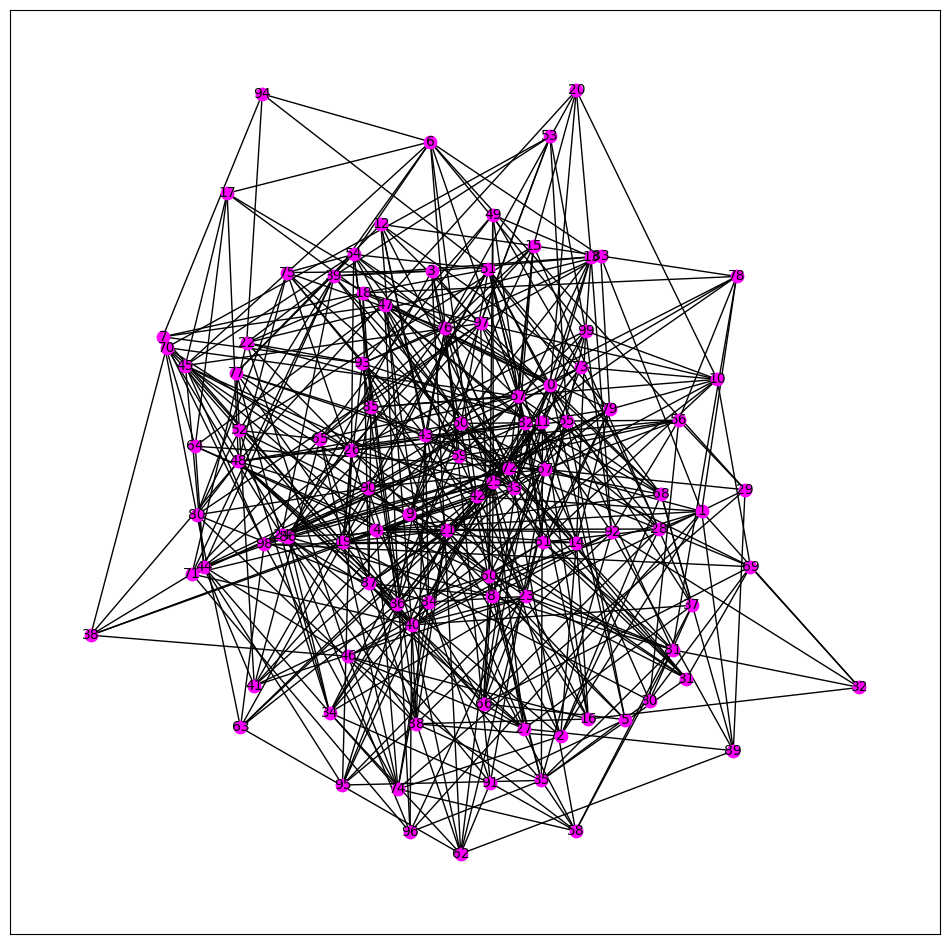

In [12]:
visualize_graph(adj_matrix)

In [13]:
dijkstra_avg_times = []
bellman_ford_avg_times = []
for _ in tqdm(range(100)):
    source_vertex = randint(0, VERT_N - 1)
    dijkstra_distances, dijkstra_avg_time = dijkstra(source_vertex, adj_matrix)
    bellman_ford_distances, bellman_ford_avg_time = bellman_ford(source_vertex, adj_list)

    if dijkstra_distances != bellman_ford_distances:
        print('Error')
        print(adj_matrix)
        print(adj_list)
        break
    dijkstra_avg_times.append(dijkstra_avg_time)
    bellman_ford_avg_times.append(bellman_ford_avg_time)

  0%|          | 0/100 [00:00<?, ?it/s]

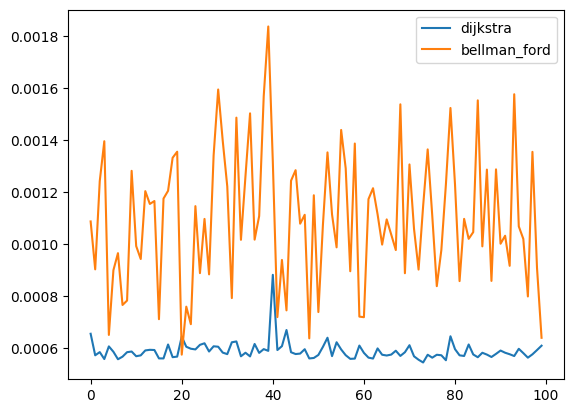

In [14]:
plt.plot(dijkstra_avg_times, label='dijkstra')
plt.plot(bellman_ford_avg_times, label='bellman_ford')
plt.legend(loc='best')

In [15]:
stats.ttest_ind(dijkstra_avg_times, bellman_ford_avg_times)

TtestResult(statistic=np.float64(-19.525128033399593), pvalue=np.float64(4.901444938384877e-48), df=np.float64(198.0))